Here I'm making a better non-parametric tree of only a subset of sequences from the bigger v2g5 tree.
The aim is to get a better resolution on the disctiotion between JOX, ANS and FLS clades.
This distinction holds up in the bigger parametric tree methods reproducibly, although not all nodes of interest have sufficient bootstrap support.
With a non-parametric method, I aim to get a better idea of how reliable these nodes are.

**data**

I'm working with a subset of sequences of the JOX, ANS and FLS clades, retrieved from the v1g3 and the v2g5 trees. These subsets are redundant so they should be deduplicated first.

**approach**
I'll get the sequences from previous allignments, build a mafft tree, trim, attampt prank indelrealignment with a iqtree guide-tree, and then build a non-parametric tree with 200 bootstrap runs.

## compile data

deduplicate the subset list:

In [39]:
sort data/v2g5_subset-ids.txt | uniq | tr ' ' _ > data/temp.txt
mv data/temp.txt data/v2g5_subset-ids.txt

(phylo_ans) 

: 1

Make a fasta from this subset list

In [40]:
grep -f data/v2g5_subset-ids.txt \
     -A 1 \
    --no-group-sep \
     data/orthogroup_AtLDOX_AT4g22880_selection-v2_guide-v5.fasta \
> data/v2g5_JOX-ANS-FLS-subset.fasta

(phylo_ans) 004l

: 1

## align with mafft

Now align this subset of data:

In [41]:
inseq=v2g5_JOX-ANS-FLS-subset

(phylo_ans) 

: 1

In [42]:
rm "./data/alignments_raw/$inseq"_aligned-mafft*
if    [ ! -d ./data/alignments_raw/ ]
then  mkdir  ./data/alignments_raw
fi
prefix=data/alignments_raw/"$inseq"_aligned-mafft-einsi
if    [ ! -f "$prefix".fasta ]
then  einsi --thread $(nproc) data/$inseq.fasta \
            >  "$prefix".fasta \
            2> "$prefix".log
fi

(phylo_ans) 

: 1

Make a snapshot:

In [43]:
prefix=data/alignments_raw/"$inseq"_aligned-mafft-einsi
jalview -nodisplay \
        -open $prefix.fasta \
        -colour CLUSTAL \
        -png  $prefix.png > /dev/null 2> /dev/null

(phylo_ans) 

: 1

In [44]:
echo $prefix.png

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.png
(phylo_ans) 

: 1

which looks like this:
![](data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.png)

This looks like a good alignment to me, with minor column trimming I will be very happy and I doubt that indel realignment is even necessary like this 

## trimming

In [45]:
ls data/alignments_raw/$inseq*.fasta

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta
(phylo_ans) 

: 1

In [52]:
if    [ ! -d data/alignments_trimmed ]
then  mkdir  data/alignments_trimmed 
fi
trimappendix='trim-gt1'

for a in "data/alignments_raw/$inseq"_aligned*.fasta
do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    if    [ ! -f data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta ]
    then  echo "trimming alignment $a"
          sed -i 's/ /_/g' $a
          trimal -in $a   \
                 -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                 -gt .1 2> /dev/null &
    fi
done

trimming alignment data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta
[1] 664134
(phylo_ans) 

: 1

In [ ]:
for   i in data/alignments_trimmed/$inseq*.fasta
do    prefix=$(echo $i | sed 's/\.fasta//')
      if    [ ! -f $prefix.png ]
      then  jalview -nodisplay \
                    -open $prefix.fasta \
                    -colour CLUSTAL \
                    -png  $prefix.png > /dev/null 2> /dev/null &
      fi
done
wait


In [ ]:
ls data/alignments_trimmed/$inseq*.png

#### gt1
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.png)
### gt4
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.png)


I'll create a guide tree out of the gt4 version, and then try to get some extra indel info out of the alignment.
It won't be much, but the gt1 version gives me the impression there might be something to gain here.

## guide tree with iqtree

In [56]:
ls data/alignments_trimmed/$inseq*.fasta

data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.fasta
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
(phylo_ans) 

: 1

In [57]:
a=data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
echo "making a iqtree fast tree of file $a"
appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
echo $appendix
if   [ ! -d   analyses/"$inseq"_fasttrees/"$appendix" ]
then mkdir -p analyses/"$inseq"_fasttrees/"$appendix"
fi

iqprefix=analyses/"$inseq"_fasttrees/"$appendix"/"$inseq"_"$appendix"_iqtree-fast
if   [ ! -f "$iqprefix".iqtree ]
then nice iqtree -s $a -fast \
                 -m 'LG+R7' \
                 -nt AUTO \
                 -ntmax $(nproc)  \
                 -pre "$iqprefix" \
                 > "$iqprefix".stdout \
                 2> "$iqprefix".stderr
else echo 'tree exists'
fi


making a iqtree fast tree of file data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
aligned-mafft-einsi_trim-gt4
(phylo_ans) 

: 1

Looking at the tree, I realise I should have included an algal outgroup like I normally do. 
Just to confidently place the root amongst some weirdly placed sequences.
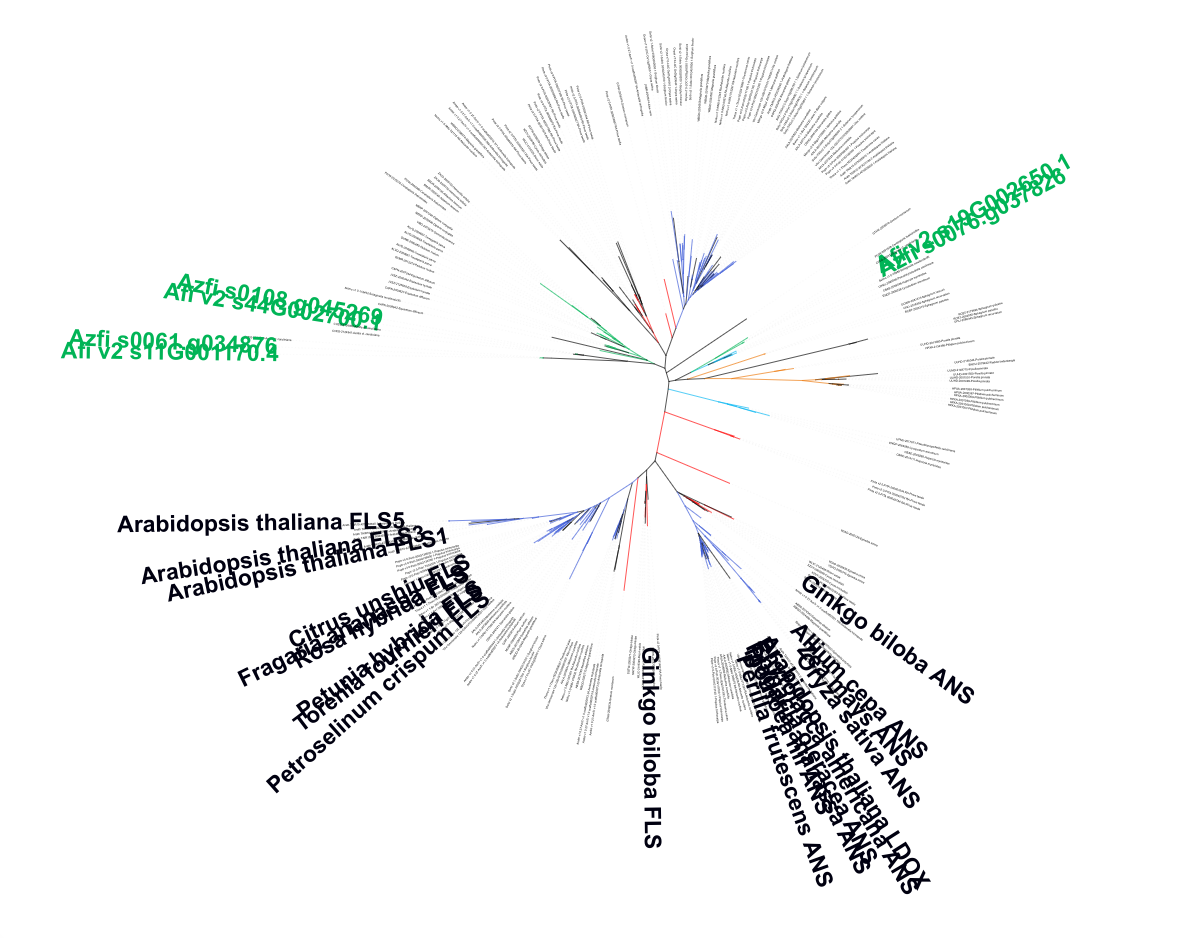

The tree with outgroup is a lot easier to read and the outgroup fits in where I expected it:
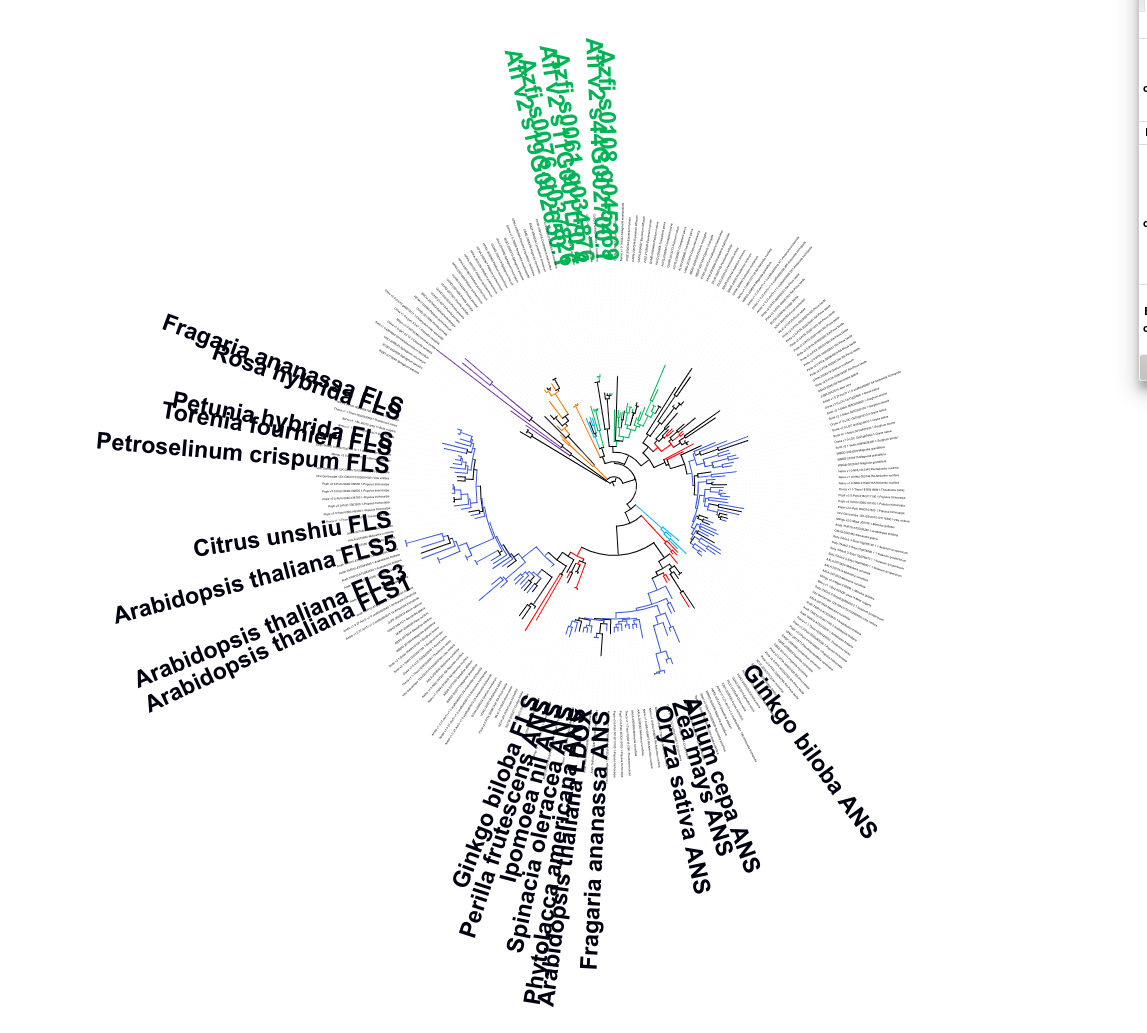

## indel relalignment with prank

Find the files I'll use:

In [59]:
ls data/alignments_raw/$inseq*.fasta

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta
(phylo_ans) 

: 1

In [60]:
ls data/alignments_trimmed/$inseq*.fasta

data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.fasta
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
(phylo_ans) 

: 1

In [62]:
ls analyses/$inseq*/*gt4/*.treefile

analyses/v2g5_JOX-ANS-FLS-subset_fasttrees/aligned-mafft-einsi_trim-gt4/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4_iqtree-fast.treefile
(phylo_ans) 

: 1

Prank takes some time but uses only one thread, so I try two things at one:

In [64]:
prank -d=data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta \
      -o=data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta \
      -t=analyses/v2g5_JOX-ANS-FLS-subset_fasttrees/aligned-mafft-einsi_trim-gt4/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4_iqtree-fast.treefile \
      -protein &

[1] 666626?2004l
(phylo_ans) 

: 1

In [70]:
mv data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta.best.fas data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta

(phylo_ans) 

: 1

In [71]:
ls data/alignments_raw/*prank*

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta
(phylo_ans) 

: 1

In [65]:
prank -d=data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.fasta \
      -o=data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta \
      -t=analyses/v2g5_JOX-ANS-FLS-subset_fasttrees/aligned-mafft-einsi_trim-gt4/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4_iqtree-fast.treefile \
      -protein & 

[2] 666916?2004l
(phylo_ans) 

: 1

In [72]:
mv data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta.best.fas data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta

(phylo_ans) 

: 1

Both allignments worked out, great!

In [83]:
ls data/alignments_*/$inseq*prank*.fasta

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank_trim-gt1.fasta
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta
(phylo_ans) 

: 1

Now let's also trim the raw-prank alignment with gt1 for a fair comparison.

In [80]:
trimappendix='trim-gt1'

for a in "data/alignments_raw/$inseq"_aligned*.fasta
do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    if    [ ! -f data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta ]
    then  echo "trimming alignment $a"
          sed -i 's/ /_/g' $a
          trimal -in $a   \
                 -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                 -gt .1 2> /dev/null &
    fi
done

trimming alignment data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.fasta?2004l
[1] 672424
(phylo_ans) 

: 1

In [81]:
for   i in data/alignments_*/$inseq*prank*.fasta
do    prefix=$(echo $i | sed 's/\.fasta//')
      if    [ ! -f $prefix.png ]
      then  jalview -nodisplay \
                    -open $prefix.fasta \
                    -colour CLUSTAL \
                    -png  $prefix.png > /dev/null 2> /dev/null &
      fi
done
wait

[1]+  Done                    trimal -in $a -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta -gt .1 2> /dev/null
[1] 672434?2004l
[1]+  Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
(phylo_ans) 

: 1

In [82]:
ls data/alignments_*/$inseq*prank*.png

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.png
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank_trim-gt1.png
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.png
(phylo_ans) 

: 1

#### raw :
![](data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.png)
#### raw with indel realign:
![](data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank.png)
#### raw with indel realing and then gt1
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi-prank_trim-gt1.png)
#### gt1 
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.png)
#### gt1 with indel realign
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.png)

The two different approaches yield vastly different results.
Pulling the raw aligment through prank, splits up the first conserved domains between one and another group of the alignment. 
My judgement is that this is an artefact of some kind, the raw and trimmed alignments (without prank) look too good to me to justify doing this.

Looking at the gt1 allignment that was processed with prank, I like the structure that I see in the gappy regions comparted to the noisy gaps in the gt1 without prank. 
This will be the alignment to build a tree of!

## iqtree

In [ ]:
a=data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta


iqpendix='iqtree-b200'
#iqpendix='iqtree-bb1000-alrt1000'

echo "making a tree of file $a"
echo "The first lines of alignment $a look like this"
head $a

file_appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
echo "Making a directory $file_appendix to store trees (name based on alignment filename)"

if   [ ! -d    analyses/"$inseq"_trees/"$file_appendix" ]
then mkdir -p  analyses/"$inseq"_trees/"$file_appendix" 
fi

iqprefix=analyses/"$inseq"_trees/"$file_appendix"/"$inseq"_"$file_appendix"_"$iqpendix"
if   [ ! -f "$iqprefix".tree ]
then nice iqtree -s $a \
                 -m MFP \
                 -b 200 \
                 -nt AUTO \
                 -ntmax $(nproc)  \
                 -pre  "$iqprefix" \
                 2>   "$iqprefix".stderr \
                 >    "$iqprefix".stdout \
                 && cat "$iqprefix".out | mail -s ANS_IQtree_run laura.w.dijkhuizen@gmail.com
fi

making a tree of file data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta
The first lines of alignment data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank.fasta look like this
>Chlre_v5_5-Cre10_g466700_t1_1-Chlamydomonas_reinhardtii
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
----------------------------------------------------------MV
Q--DVP------IIDMSAPE----AAAAA-----------AVR--------------A--
-AAAGSGFFYVT-----------QHGVSDQLVAE--AFAQQRALFALPQETKMALLQDAN
NRGYTP-TL---DPANQKHGD--TKEGFYFGVAPDPLHGPNQWPDLLPDYRRVTWQYYE-
---------ALNALGMRLLRLLAL-SLDLPAEHFTP-MFTA--P--LV-TLRPLHYAEVS
Making a directory aligned-mafft-einsi_trim-gt1_prank to store trees (name based on alignment filename)
(phylo_ans) 

Tree: 
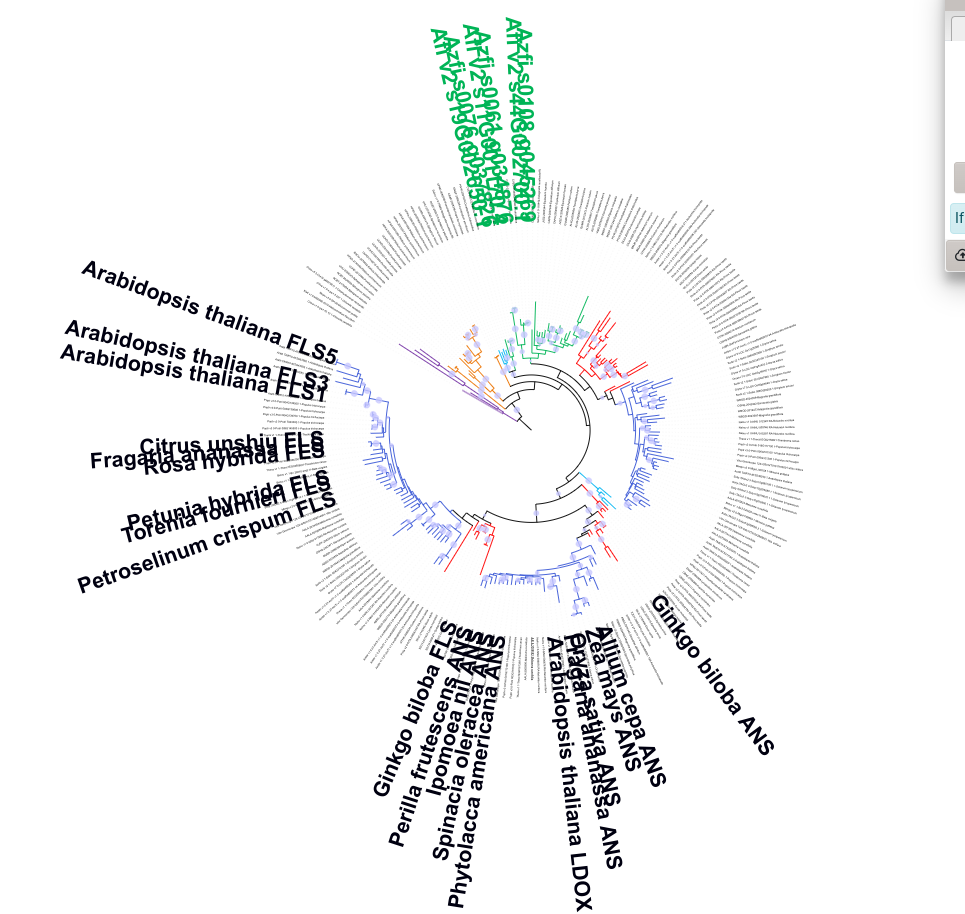

I'm quite happy with how this tree turned out, unfortunately there's no bootstrap support for the higher branches.
This is quite common for this type of bootstrap, so I'll calculate transferbootstrap instead to get a better idea of how trustworthy these nodes are.


In [87]:
conda activate booster
inseq='v2g5_JOX-ANS-FLS-subset'
for t in ./analyses/"$inseq"_trees/aligned*/*.boottrees
do  prefix=$(echo $t | sed 's/\.boottrees//g')
    booster -i $prefix.treefile \
            -b $t \
            -o "$prefix"_booster.treefile \
            -c \
            -S "$prefix"_booster.stats \
            -r "$prefix"_booster.raw
done
conda deactivate

**************************
*         Options        *
**************************
booster : version 0.1.2
Input Tree      : ./analyses/v2g5_JOX-ANS-FLS-subset_trees/aligned-mafft-einsi_trim-gt1_prank/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank_iqtree-b200.treefile
Bootstrap Trees : ./analyses/v2g5_JOX-ANS-FLS-subset_trees/aligned-mafft-einsi_trim-gt1_prank/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank_iqtree-b200.boottrees
Output tree     : ./analyses/v2g5_JOX-ANS-FLS-subset_trees/aligned-mafft-einsi_trim-gt1_prank/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank_iqtree-b200_booster.treefile
Output raw tree : ./analyses/v2g5_JOX-ANS-FLS-subset_trees/aligned-mafft-einsi_trim-gt1_prank/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank_iqtree-b200_booster.raw
Stat file       : ./analyses/v2g5_JOX-ANS-FLS-subset_trees/aligned-mafft-einsi_trim-gt1_prank/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1_prank_iqtree-b200_booster.stats
Algo    

: 1

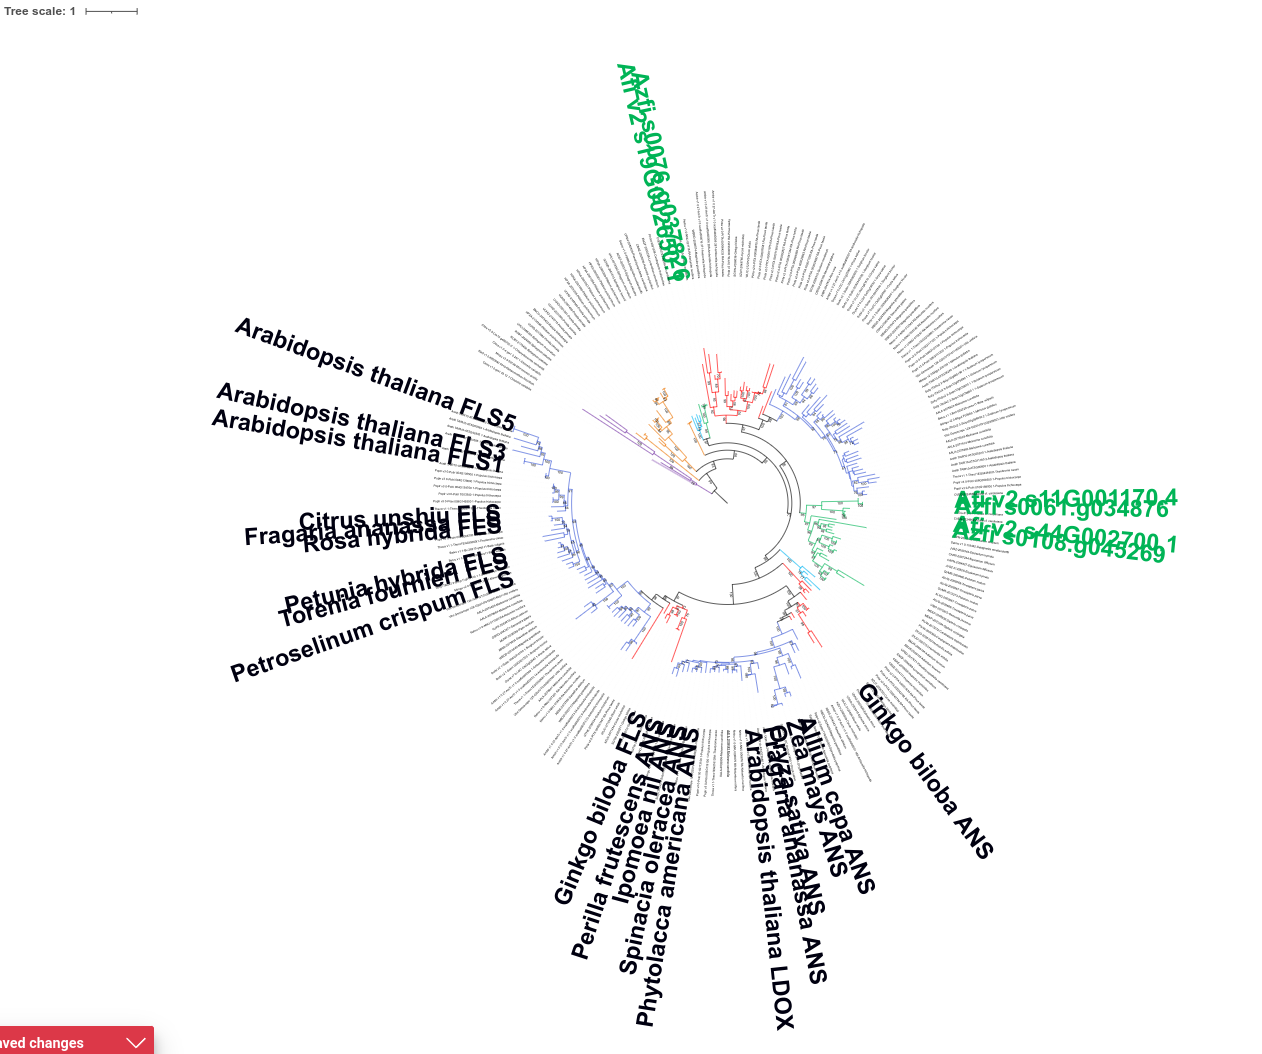

with collapsed clades: 
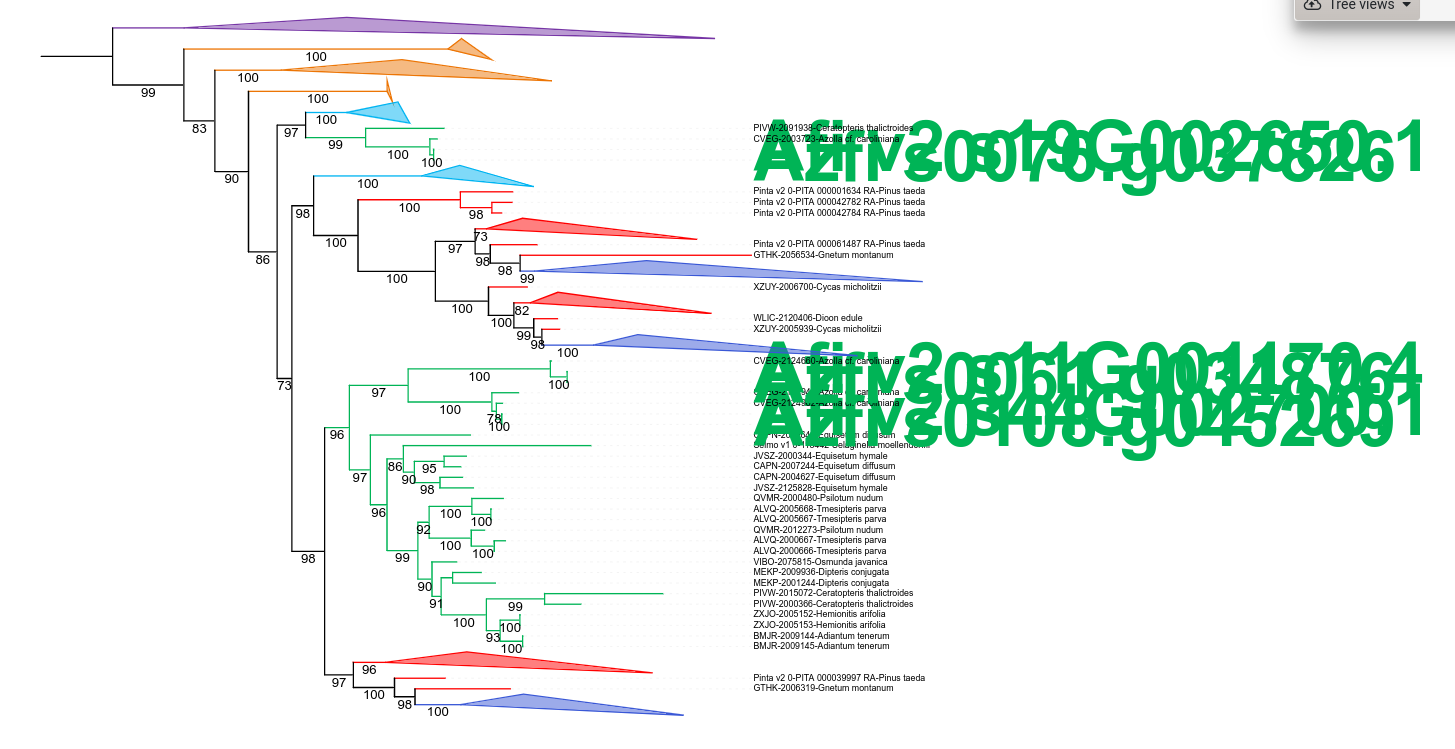